## Kepler 62f Example

In this Jupyter notebook we will provide an example of how to apply the ```HZ_evolution``` package to an actual system. In this scenario we will demonstrate how we can characterize the instellation history and habitable durations (with uncertainties) of the example planet Kepler 62f.

Kepler 62f is a planet with a radius of around 1.4 $R_{\oplus}$ with a period of P = 267.29 days around an early K star. Given its radius it is likely a rocky super-Earth, and its period places it squarely in the habitable zone of the star. This makes it one of our best examples of a habitable zone planet around an FGK star.

In this example we will fit a stellar model to Kepler 62 and characterize the habitable history of Kepler 62f. Our goal here is not necessarily to accurately obtain a new estimate of the star's fundamental properties, but to demonstrate that we can constrain the planet's habitable duration and instellation history from a given model fit.

**IMPORTANT**: This example uses the model grid of habitable durations calculated by the ```calculate_grid_4D```. If you have not constructed a model grid please do so before running this example. An example of how to construct a model grid is provided in the ```Intro_to_HZ_evolution.ipynb``` notebook.

We start by importing several packages we will use and setting up the multiprocessing method

In [1]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1" #prevent numpy from using multiple cores
import pandas as pd
import emcee
import numpy as np
from isochrones.mist import MIST_EvolutionTrack
from isochrones.interp import DFInterpolator
import scipy.stats as st
import matplotlib.pyplot as plt
import isochrones.priors as priors
import multiprocessing as mp
mp.set_start_method('fork')

PyMultiNest not imported.  MultiNest fits will not work.


We can ignore any warnings about PyMultiNest as we are not using it in this example

Next we import the ```HZ_evolution``` package

In [2]:
import HZ_evolution as hz

We will then specify the observed stellar properties for the host star Kepler 62. We gather these from two literature sources: Borucki et al (2018) and Fulton and Petigura (2018). We compile these observed properties in a dictionary object ```target_dict```

In [3]:
#Kepler 62 properties
star_Teff=5062 #borucki+ 2018
star_dTeff=71
star_logg=4.683 #borucki+ 2018
star_dlogg=0.023
star_feh= -0.34 #fulton and petigura 2018
star_dfeh=0.04
star_logL= -0.5909 #borucki+ 2018
star_dlogL= 0.0077
star_mass=0.764 #borucki+ 2018
star_dmass=0.011
target_dict={'Teff':(star_Teff,star_dTeff),
             'logg':(star_logg,star_dlogg*4),
             'feh':(star_feh,star_dfeh*2),
             'logL':(star_logL,star_dlogL),
             'mass':(star_mass,star_dmass*10)}
#constant factors in the target dict represent adjustments to the likelihood function to prioritize certain properties over others

We will fit a model to this star using the MIST evolutionary tracks so we import the evolutionary track object as ```mist_track```

In [4]:
mist_track = MIST_EvolutionTrack()

For the MIST model we are fitting we have a set of input parameters in the form:

pars = [initial_mass, eep, initial_feh]

We will specify the priors for our MCMC fitting, allowing the parameters to vary within a reasonable range while also making sure the chains don't get lost far away from the posterior maximum.

In [5]:
prior_arr=[st.norm(loc=0.75,scale=0.05),
           st.uniform(loc=200,scale= 300),  #max eep 350 corresponds to 35 Gyr age for mass upper bound
           st.norm(loc= -0.35,scale=0.5)]

We then define a function for our posterior using the default log_posterior function but specifying all arguments except the parameters we are fitting

In [6]:
prop_names=['Teff', 'logg', 'feh', 'logL','mass']

def ln_post_global(pars):
    ln_post =hz.log_posterior(pars, target_dict, prop_names, 
                           mist_track, prior_arr,[])
    return ln_post

We set the number of dimensions, walkers, and samples for our MCMC chain and generate a random starting point for the MCMC chains via sampling from the prior distribution

In [7]:
ndim=3
nwalkers=32 #32
nsamples=20000 #10000

p0=hz.sample_prior(nwalkers, ndim, prior_arr,special_ind=[])

Next we run the ```emcee``` mcmc chain to fit our model. We use multiprocessing to speed it up.

In [8]:
#%% multiprocessing version (not working for some reason)
if __name__ == '__main__':
    with mp.Pool() as mcmcpool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post_global, 
                                        pool=mcmcpool)
        sampler.run_mcmc(p0, nsamples, progress=True)

    samples=sampler.get_chain()
    #sampler.reset()
print("done")

100%|████████████████████████████████████| 20000/20000 [00:36<00:00, 555.16it/s]


done


We can observe the performance of our MCMC chains with a trace plot constructed below. It may be a bit visually crowded as we are showing all 32 walkers in each panel

Text(0.5, 0, 'step number')

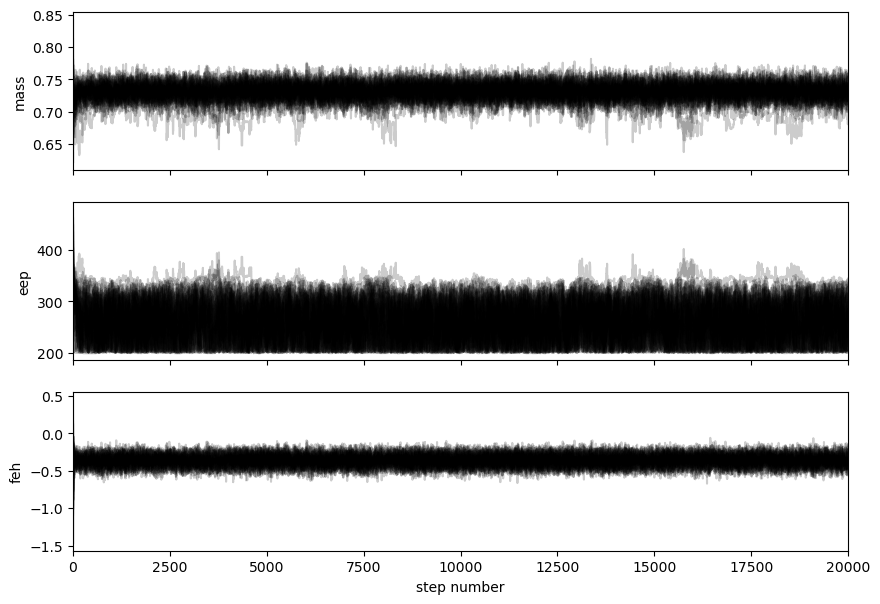

In [9]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["mass", "eep", "feh"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")

We can then flatten our MCMC chain, aggregating the results from all walkers, and construct a corner plot.

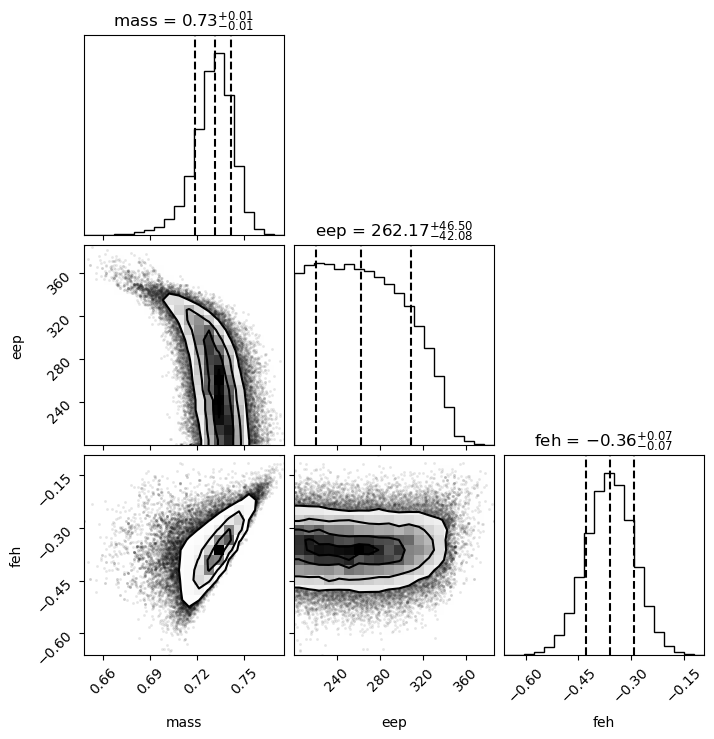

In [10]:
flat_samples = sampler.get_chain(discard=600,thin=10, flat=True)

import corner
corner_fig = corner.corner(flat_samples,labels=labels,quantiles=[0.16, 0.5, 0.84],show_titles=True)

One can see that our MCMC chain have converged properly. The mass and [Fe/H] of the star are well constrained by the model, whereas the EEP and by extension the stellar age are more roughly constrained to be on the early main sequence.

We would like to see the distribution of values for the habitable duration and times spent outside the HZ, and to do this we will construct an interpolator for these properties over the tabulated model grid. In order for the construction of this interpolator to not take too much RAM, we focus on the region of parameter space explored by the MCMC chains. We calculate the minimum and maximum of each input parameter and use them as arguments for the ```construct_interpolator_4D``` function.

In [11]:
mass_min=flat_samples[:,0].min()
mass_max=flat_samples[:,0].max()
mass_quants=np.quantile(flat_samples[:,0],[0.16, 0.5, 0.84] )

eep_min=flat_samples[:,1].min()
eep_max=flat_samples[:,1].max()
eep_quants= np.quantile(flat_samples[:,1], [0.16, 0.5, 0.84])

feh_min=flat_samples[:,2].min()
feh_max=flat_samples[:,2].max()
feh_quants= np.quantile(flat_samples[:,2], [0.16, 0.5, 0.84])

Seff_min=0.1
Seff_max=2.1

func_4d=hz.construct_interpolator_4D(feh_min=feh_min,feh_max=feh_max,mass_min= mass_min,mass_max= mass_max,
                           eep_min=eep_min,eep_max=eep_max,Seff_min=0.1,Seff_max=2.1)

We then run a for loop to get the values of $S_{eff}$, age, $\tau$, $t_{int}$, and $t_{ext}$ for each point in the MCMC chain.

In [14]:
mist_cols=['mass','logL','age']

n_points= flat_samples.shape[0]

Seff_arr=np.ones(n_points)*np.nan
age_arr=np.ones(n_points)*np.nan
tau_arr=np.ones(n_points)*np.nan
t_int_arr=np.ones(n_points)*np.nan
t_ext_arr=np.ones(n_points)*np.nan

#K2-18 b properties
Period= 267.29 

for i in range(n_points):
    pars=flat_samples[i,:]
    temp_output= hz.model_output(pars,prop_names=mist_cols,mist_track=mist_track)
    L=10**temp_output['logL']
    Seff= hz.P_to_Seff(Period,temp_output['mass'],L)
    #parameters in the form ['initial_Fe_H','initial_mass','EEP','S_eff']
    alt_pars=[flat_samples[i,2],flat_samples[i,0],flat_samples[i,1],Seff]
    temp_tau_arr= func_4d(alt_pars)
    
    Seff_arr[i]=Seff
    age_arr[i]=temp_output['age']
    tau_arr[i]= temp_tau_arr[0]
    t_int_arr[i]= temp_tau_arr[1]
    t_ext_arr[i]= temp_tau_arr[2]
    
    

Now lets plot the output of our model fitting.

First we plot a histogram of log(age / yrs)

Text(0.5, 1.0, 'log(age)= $8.67 ^{+0.71} _{- 0.63}$')

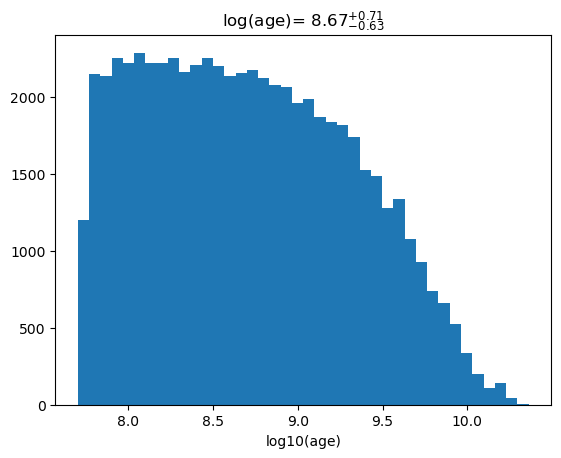

In [20]:
age_fig, age_ax= plt.subplots()
age_ax.hist(age_arr, bins=40)
age_ax.set_xlabel("log10(age)")

age_quant= np.quantile(age_arr,[0.16, 0.5, 0.84] )
age_ax.set_title(r'log(age)= $%.2f ^{+%.2f} _{- %.2f}$'% (age_quant[1], age_quant[2]-age_quant[1],age_quant[1]-age_quant[0]))

Next we construct a histogram for $\tau$ the habitable duration (the time the planet has spent in the HZ)

Text(0.5, 1.0, '$\\log(\\tau)= 8.68 ^{+0.70} _{- 0.63}$')

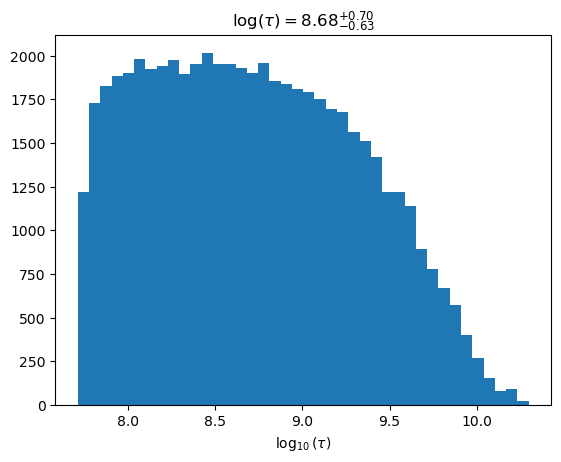

In [23]:
tau_fig, tau_ax= plt.subplots()
tau_ax.hist(np.log10(tau_arr), bins = 40)
tau_ax.set_xlabel(r'$\log_{10}(\tau)$')
tau_quant=np.nanquantile(np.log10(tau_arr),[0.16, 0.5, 0.84] )
tau_ax.set_title(r'$\log(\tau)= %.2f ^{+%.2f} _{- %.2f}$'% (tau_quant[1], tau_quant[2]-tau_quant[1],tau_quant[1]-tau_quant[0]))

One can see that the distribution of log(age) is very similar to the distribution of log($\tau$) this tells us that we essentially can constrain $\tau$ as well as we can constrain the stellar age. This might be discouraging as ages are very difficult to constrain, but we will demonstrate that even when ages remain uncertain we can still do a good job constraining the time spent outside the HZ and the planet's instellation history.

Let's now make a histogram for time spent interior to the habitable zone

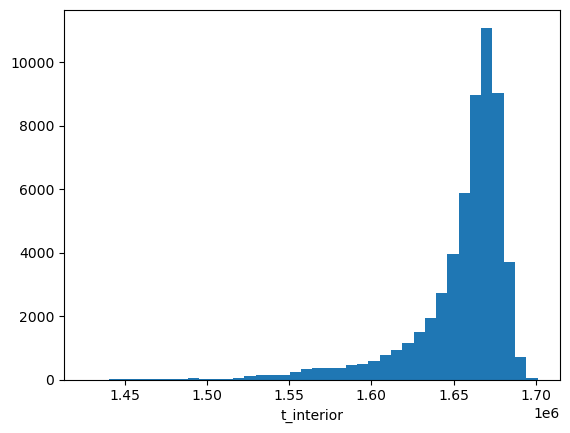

In [24]:
t_int_fig, t_int_ax =plt.subplots()
t_int_ax.hist(t_int_arr, bins=40)
t_int_ax.set_xlabel('t_interior')
t_int_quant=np.nanquantile(t_int_arr,[0.16, 0.5, 0.84])

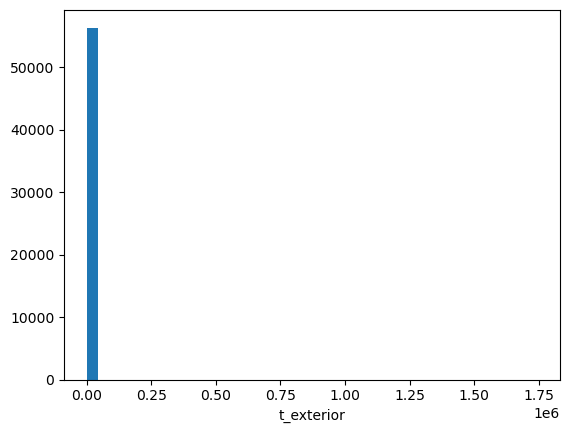

In [25]:
t_ext_fig, t_ext_ax =plt.subplots()
t_ext_ax.hist(t_ext_arr, bins=40)
t_ext_ax.set_xlabel('t_exterior')
t_ext_quant=np.nanquantile(t_ext_arr,[0.16, 0.5, 0.84])

In [30]:
best_pars= [mass_quants[1],eep_quants[1],feh_quants[1]]
track_cols=['age','logL','Teff']
n_eep=400

start_age=0.0

trackdf=hz.generate_interpolated_evol_track(best_pars,track_cols=track_cols,n_eep=n_eep,mist_track=mist_track)
best_d_planet = hz.P_to_d(Period, best_pars[0]) 
age_input= 10**trackdf['age'].values
L_input= 10**trackdf['logL'].values
Teff_input= trackdf['Teff'].values
best_planet_obj= hz.HZ_planet(age_input,L_input,Teff_input,Dist=best_d_planet,
                         HZ_form="K13_optimistic")

cond= (age_input>=start_age)  
best_time_bp= age_input[-1] -age_input

#best_S_arr=best_planet_obj.Seff

#best_time_bp=best_time_bp[cond]
#best_S_arr=best_S_arr[cond]


hz_inner_flux= best_planet_obj.S_inner#hz.hz_flux_boundary(best_planet_obj.Teff[cond],hz.c_recent_venus)
hz_outer_flux= best_planet_obj.S_outer#hz.hz_flux_boundary(best_planet_obj.Teff[cond],hz.c_early_mars)

hz_width=hz_inner_flux-hz_outer_flux
best_hz_pos= (best_planet_obj.Seff - hz_outer_flux)/hz_width

In [31]:
#%% make loop to get Seff
ntracks=100
time_arr= np.empty((ntracks,n_eep))
#S_eff_arr= np.empty((ntracks,n_eep))
#age_track_arr=np.empty((ntracks,n_eep))
#hz_inner_arr=np.empty((ntracks,n_eep))
#hz_outer_arr=np.empty((ntracks,n_eep))
planet_arr=np.empty(ntracks, dtype=hz.HZ_planet)
hz_pos_arr=np.empty((ntracks,n_eep))

rand_inds=np.random.randint(len(flat_samples),size=ntracks)

for q in range(ntracks):
    ind= rand_inds[q]
    pars=flat_samples[ind,:]
    d_planet = hz.P_to_d(Period, pars[0])
    temptrack=hz.generate_interpolated_evol_track(pars,track_cols=track_cols,n_eep=n_eep,mist_track=mist_track)
    age_input= 10**temptrack['age'].values
    L_input= 10**temptrack['logL'].values
    Teff_input= temptrack['Teff'].values
    temp_planet=hz.HZ_planet(age_input,L_input,Teff_input,Dist=d_planet,
                             HZ_form="K13_optimistic")
    
    planet_arr[q]=temp_planet
    time_bp= age_input[-1] -age_input
    time_arr[q,:]= time_bp
    
    width =temp_planet.S_inner - temp_planet.S_outer
    hz_pos= (temp_planet.Seff-temp_planet.S_outer)/width
    hz_pos_arr[q,:]=hz_pos
    #age_track_arr[q,:]=age_input

    #S_arr=temp_planet.Seff
    #S_eff_arr[q,:]= S_arr
    
#could plug into Planet object

#temp_output= model_output(pars,prop_names=mist_cols,mist_track=mist_track)
#L=10**temp_output['logL']
#eff= hz.P_to_Seff(Period,temp_output['mass'],L)

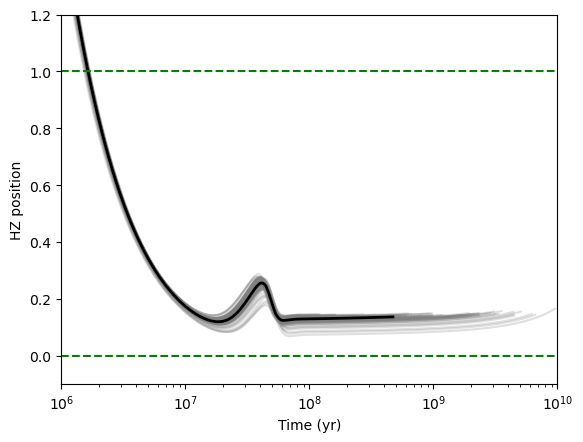

In [32]:
#%%plotting tracks

S_fig, S_ax = plt.subplots()

for j in range(ntracks):
    planet_obj=planet_arr[j]
    #cond= (age_track_arr[j,:]>=start_age)
    #S_ax.plot(time_arr[j,cond],S_eff_arr[j,cond],color='gray',alpha=0.25)
    S_ax.plot(planet_obj.age,hz_pos_arr[j,:],color='gray',alpha=0.25)

S_ax.plot(best_planet_obj.age,best_hz_pos,color='black',lw=2)

S_ax.axhline(y=1,color='green',ls='--')
S_ax.axhline(y=0,color='green',ls='--')
#S_ax.plot(best_time_bp,hz_inner_flux,color='green',ls='--')
#S_ax.plot(best_time_bp,hz_outer_flux,color='green',ls='--')

#S_ax.invert_xaxis()
S_ax.set_xlabel("Time (yr)")
S_ax.set_ylabel("HZ position")
S_ax.set_xlim([1e6,1e10])
S_ax.set_ylim([-0.1,1.2])
S_ax.set_xscale('log')
#S_ax.set_yscale('log')

(0.0, 2.0)

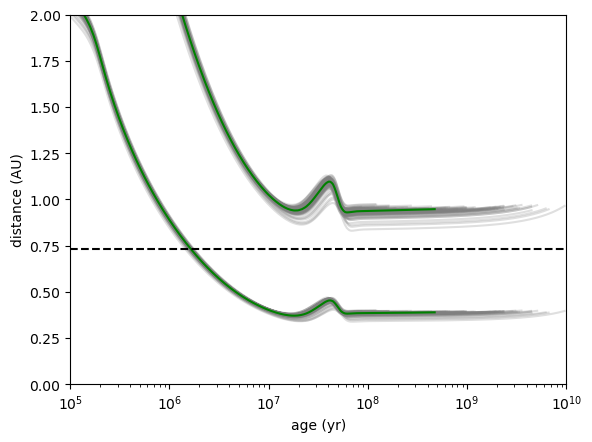

In [33]:
hz_fig, hz_ax= plt.subplots()

for k in range(ntracks):
    planet_obj=planet_arr[k]
    hz_ax.plot(planet_obj.age,planet_obj.r_inner,color='gray',alpha=0.25)
    hz_ax.plot(planet_obj.age,planet_obj.r_outer,color='gray',alpha=0.25)
    #hz_ax.axhline(y=planet_obj.Dist,color='gray',alpha=0.05)

hz_ax.plot(best_planet_obj.age,best_planet_obj.r_inner,ls='-',color='green')
hz_ax.plot(best_planet_obj.age,best_planet_obj.r_outer,ls='-',color='green')

hz_ax.axhline(y=best_planet_obj.Dist,ls='--',color='black')
hz_ax.set_xlim([1e5,1e10])
hz_ax.set_xscale("log")
hz_ax.set_xlabel("age (yr)")
hz_ax.set_ylabel("distance (AU)")
hz_ax.set_ylim([0,2])